In [9]:
# To Create the Jupyter Slides Type:
# jupyter nbconvert *.ipynb --to slides

# Detailed Balanced Chemical Reaction Networks are Generalized Boltzmann Machines

 __William Poole__ (1), Tom Ouldridge (2), Manoj Gopalkrishnan (3), and Erik Winfree (1)
(1) Caltech
(2) Imperial College London
(3) IIT Bombay

_To Navigate. __Down Arrow:__ More Details. __Right/Left Arrows:__ Prev/Next Section. __Escape:__ Poster View._

## 1.0 Abstract

Stochastic Chemical Reaction Networks (CRNs) represent a biophysically realistic and expressive modeling framework for biological systems. Detailed Balanced CRNs (dbCRNs) are a subclass of CRNs which admit an equilibrium distribution. This poster builds off our previous work on [Chemical Boltzmann Machines (Poole et al. DNA 2017)](https://arxiv.org/abs/1707.06221) where we have shown that dbCRNs can exactly implement a stochastic neural network model called a [Boltzmann Machine](https://www.sciencedirect.com/science/article/abs/pii/S0364021385800124). This relationship illustrates that stochasticity can be advantageous because it allows a CRN to compactly represent complex distributions. We have shown that these CRNs are capable of inference, defined as computing conditional distributions, by “clamping” a subset of their species to a particular value. Finally, we have shown that the equilibrium distributions of dbCRNs can be learned by an external in silico non-CRN algorithm that tunes the energies of individual molecular species. 

In new work, we have shown that the above results regarding inference and learning apply to any dbCRN, not just the Chemical Boltzmann Machine constructions. In this interactive poster, we examine physical processes that can tune species’ energies and are potentially implementable in a cell-like environment. The first uses a special kind of detailed balanced chemostat to control carefully designed chemical potentials that maintain detailed balance. The second uses a simple feedback circuit implemented as a non-detailed balanced CRN. These constructions provide equilibrium and non-equilibrium physical implementations that control the inference and learning process in dbCRNs. We then analyze these processes thermodynamically to provide lower bounds on the costs of inference andlearning. These results illustrate possible mechanisms whereby a biochemical system in a smallvolume, such as a cell, can represent and adapt to its environment.

## 1.1 Boltzmann machine background
[Boltzmann Machines (BMs)](https://www.sciencedirect.com/science/article/abs/pii/S0364021385800124) are an inspiration for this work. Briefly, they are a class of energy based machine learning models. BMs link machine learning and physics and can be defined equivalently in terms of graphical models, generalized Ising models, or stochastic Hopfield networks. In terms of this work, BMs provide two important sources of inspiration:

### 1) BMs naturally perform inference (computing conditional distributions) when some of their nodes are held constant.
 


<table>
    <tr>
        <td style="text-align:center">P(V, H) </td>
        <td style="text-align:center">P(V | H)</td>
        <td style="text-align:center">P(H | V)</td>
    </tr>
    <tr>
        <td> <img src="BM_free.gif" alt="Drawing" style="width: 250px;"/> </td>
        <td> <img src="BM_clamped1.gif" alt="Drawing" style="width: 250px;"/> </td>
        <td> <img src="BM_clamped2.gif" alt="Drawing" style="width: 250px;"/> </td>
    </tr>
</table>

### 2) BMs make use of marginalization over hidden nodes in order to produce more complex distributions.

## 1.2 Chemical reaction network background

Chemical Reaction Networks (CRNs) are a set of species $S$ and reactions $R$ of the form $\sum_i I_i S_i \to \sum_i O_i S_i$ where $I_i, O_i \in \mathbb{Z}_{\geq 0}$ are integer number of inputs and outputs of species $S_i$.

In this work, we consider stochastic chemical reaction networks which model species' counts on the integer lattice as a Markov jump process as opposed to modeling the concentrations of molecular species. This is appropriate when considering small volumes with relatively few molecules, where stochasticity is known to be important.

We further are primarily interested in a subclass of CRNs called detailed balanced (dbCRNs). There are many important theorems related to dbCRNs. In particular, they are amenable to thermodynamic and statistical mechanical analysis because they admit an equilibrium distribution.

Note: we do not restrict ourselves to bimolecular CRNs because (with some $\epsilon$ of error) high order reactions can be represented as multiple bimolecular reactions.

## 1.3 CRN terminology
* The __Reachability Class__ of a CRN are the set of states $\Omega(x_0)$ reachable via any series of reactions from an initial condition $x_0$.


* The __Stoichiometric Compatability Class__ of a CRN is the kernel of the stoichiometric matrix $\mathbb{S} = O - I$, where $O^r_i$ and $I^r_i$ are the outputs and inputs of species $i$ in reaction $r$, respectively.


* A CRN is detailed  __Detailed Balanced__ if:
  * that every species $S_i$ has an associated energy $E_i$.
  * all reactions are reversible $\sum_i I^r_i S_i \to \sum_i O^r_i S_i \implies \sum_i O^{r'}_i S_i \to \sum_i I^{r'}_i S_i$.
  * reaction rates rates are set by the detailed balanced condition $\frac{k_r^+}{k_r^-} = e^{\Delta E_r}$ where $\Delta E_r = \sum_i I^r_i E_i - O^r_i E_i$ where $r$ is the index of a reaction with forward and reverse rates $k_r^+$ and $k_r^-$.

In [10]:
max_time = 100000 #Shorten this for faster, but less accurate, simulations


#*********************************************************
#************* HELPER FUNCTIONS DEFINED HERE *************
#********** RUN THIS CELL BUT DO NOT CHANGE IT! **********
#*********************************************************

%matplotlib inline
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model
import numpy as np
import pylab as plt
from scipy.sparse import csc_matrix
import matplotlib
from time import process_time


def db_rxns(inputs, outputs, EnergyDict, k = 1):
    dE = sum([EnergyDict[o] for o in outputs])-sum([EnergyDict[i] for i in inputs])
    rxn1 = [list(inputs), list(outputs), "massaction", {"k":k*np.exp(-dE/2)}]
    rxn2 = [list(outputs), list(inputs), "massaction", {"k":k*np.exp(dE/2)}]
    return [rxn1, rxn2]

def chemostat_reactions(inputs, outputs, kf, kr):
    rxn1 = [inputs, outputs, "massaction", {"k":kf}]
    rxn2 = [outputs, inputs, "massaction", {"k":kr}]
    
    return [rxn1, rxn2]

def create_product_poisson_crn(E1 = -2, E2 = -2, E3 = -3, n = 0):
    E = {"X1":E1, "X2":E2, "X3":E3}
    species = ["X1", "X2", "X3"]
    reactions = db_rxns([], ["X1"], E)+db_rxns([], ["X2"], E) + db_rxns([], ["X3"], E)
    CRN = Model(species = species, reactions = reactions, initial_condition_dict = {"X1":n, "X2":0, "X3":0})
    return CRN

def create_restricted_CRN(E1 = -2, E2 = -2, E3 = 0, n = 30):
    E = {"X1":E1, "X2":E2, "X3":E3}
    species = ["X1", "X2", "X3"]
    reactions = db_rxns(["X1"], ["X2"], E)+db_rxns(["X2"], ["X3"], E)
    CRN = Model(species = species, reactions = reactions, initial_condition_dict = {"X1":n,"X2":0, "X3":0})
    return CRN

def create_happy_sad_CRN(E_C_s = 0, E_C_h = 0, E1 = 0, E2 = 0, n = 1):
    #Happy Face Array
    A_happy = np.zeros((10, 10)); A_happy[7, 3] = .5; A_happy[6, 3] = 1; A_happy[7, 6] = .5; A_happy[6, 6] = 1; A_happy[3, 2] = .5; A_happy[3, 7] = .5; A_happy[2, 3] = 1; A_happy[2, 6] = 1; A_happy[2, 4] = 1; A_happy[2, 5] = 1
    #Sad Face Array
    A_sad = np.zeros((10, 10)); A_sad[7, 3] = 1; A_sad[6, 3] = .5; A_sad[7, 6] = 1; A_sad[6, 6] = .5; A_sad[3, 2] = .5; A_sad[3, 7] = .5; A_sad[4, 3] = 1; A_sad[4, 6] = 1; A_sad[4, 4] = 1; A_sad[4, 5] = 1

    
    species = ["X1", "X2", "C_h", "C_s"]
    reactions = []
    E = {"X1":E1, "X2":E2, "C_h": E_C_h, "C_s":E_C_s}

    species_h = []
    species_s = []
    for i in range(10):
        for j in range(10):

            if A_sad[i, j] != 0:
                #Add sad pixel species
                s = "P_s_"+str(i)+"_"+str(j)
                species_s += [(s, i, j)]
                E[s] = -np.log(A_sad[i, j])-np.log(np.math.factorial(i))-np.log(np.math.factorial(j))

                #Add sad pixel reactions
                if len(species_s)>1:
                    s_prev, i_prev, j_prev = species_s[-2]
                    delta_i = i_prev - i
                    delta_j = j_prev - j
                    inputs = ["C_s", s_prev]
                    outputs = ["C_s", s]

                    if delta_i > 0:
                        inputs += delta_i * ["X2"]
                    elif delta_i < 0:
                        outputs += -delta_i *["X2"]

                    if delta_j > 0:
                        inputs += delta_j * ["X1"]
                    elif delta_j < 0:
                        outputs += -delta_j *["X1"]

                    reactions += db_rxns(inputs, outputs, E)


            if A_happy[i, j] != 0:
                #Add happy pixel species
                s = "P_h_"+str(i)+"_"+str(j)
                species_h += [(s, i, j)]
                E[s] = -np.log(A_happy[i, j])-np.log(np.math.factorial(i))-np.log(np.math.factorial(j))

                #Add happy pixel reactions
                if len(species_h)>1:
                    s_prev, i_prev, j_prev = species_h[-2]
                    delta_i = i_prev - i
                    delta_j = j_prev - j
                    inputs = ["C_h", s_prev]
                    outputs = ["C_h", s]

                    if delta_i > 0:
                        inputs += delta_i * ["X2"]
                    elif delta_i < 0:
                        outputs += -delta_i *["X2"]

                    if delta_j > 0:
                        inputs += delta_j * ["X1"]
                    elif delta_j < 0:
                        outputs += -delta_j *["X1"]

                    reactions += db_rxns(inputs, outputs, E)

    #Create a reaction switching happy to sad
    s_h, i_h, j_h = species_h[0]
    s_s, i_s, j_s = species_s[0]
    inputs = ["C_s", s_s]
    outputs = ["C_h", s_h]

    delta_i = i_s - i_h
    delta_j = j_s - j_h

    if delta_i > 0:
        inputs += delta_i * ["X2"]
    elif delta_i < 0:
        outputs += -delta_i *["X2"]

    if delta_j > 0:
        inputs += delta_j * ["X1"]
    elif delta_j < 0:
        outputs += -delta_j *["X1"]

    reactions += db_rxns(inputs, outputs, E)
    species += [i[0] for i in species_h] + [i[0] for i in species_s]
    CRN = Model(
        species = species,
        reactions = reactions, 
        initial_condition_dict = {"X1":j_h, "X2":i_h, "C_h":n, "C_s":0, s_h:n, s_s:0})
    
    return CRN

def bar_marginal(x, y, reverse = False, **keywords):
    new_x = [0]
    new_y = [0]
    for i in range(len(x)-1):
        new_x += [x[i], x[i+1]]
        new_y += [y[i], y[i]]
    new_x += [x[-1]]
    new_y += [0]
    if reverse:
        plt.plot(new_y, new_x, **keywords)
    else:
        plt.plot(new_x, new_y, **keywords)
    
def learning_XOR_CRN(EP = 0, P0 = 0, k_db = 1.0,
                     k = .1, kr = .001, k_Q = .1,
                     E_Q = {"QX0":1, "QX1":-1, "QY0":1, "QY1":-1, "QW0":0, "QW1":4}):
    species = ["X0", "X1", "PX0", "PX1", "Y0", "Y1","PY0", "PY1", "W0", "W1","PW0", "PW1"]
    E = {s:EP*int("P" in s) for s in species}
    reactions = []
    #These reactions implement a potential chemostat on X, Y, and W
    reactions += db_rxns(["X0", "Y0", "PX0"], ["X1", "Y0", "PX1"], E, k = k_db)
    reactions += db_rxns(["X0", "Y0", "PY0"], ["X0", "Y1", "PY1"], E, k = k_db)
    reactions += db_rxns(["X1", "Y0", "W0", "PY0", "PW0"], ["X1", "Y1", "W1", "PW1", "PY1"], E, k = k_db)
    reactions += db_rxns(["X0", "Y1", "W0", "PX0", "PW0"], ["X1", "Y1", "W1", "PW1", "PX1"], E, k = k_db)

    #These reactions implement the learning rule
    species += ["QX0", "QY0", "QW0", "QX1", "QY1", "QW1"]
    reactions += chemostat_reactions(["QX0", "PX0"], ["QX0"], k, kr)
    reactions += chemostat_reactions(["QY0", "PY0"], ["QY0"], k, kr)
    reactions += chemostat_reactions(["QW0", "PW0"], ["QW0"], k, kr)
    reactions += chemostat_reactions(["X0", "PX0"], ["X0", "PX0", "PX0"], k, kr)
    reactions += chemostat_reactions(["Y0", "PY0"], ["Y0", "PY0", "PY0"], k, kr)
    reactions += chemostat_reactions(["W0", "PW0"], ["W0", "PW0", "PW0"], k, kr)

    
    x0 = {"X0":0, "X1":1,"PX":10, "Y0":0, "Y1":1, "PX0":P0, "PX1":P0, "PY1":P0, "PY0":P0, "W0":0, "W1":1, "PW1":P0, "PW0":P0}

    reactions += db_rxns(["QX0", "QY0"], ["QX1", "QY0"], E_Q, k=k_Q)
    reactions += db_rxns(["QX0", "QY0"], ["QX0", "QY1"], E_Q, k=k_Q)
    reactions += db_rxns(["QX1", "QY0", "QW0"], ["QX1", "QY1", "QW1"], E_Q, k=k_Q)
    reactions += db_rxns(["QX0", "QY1", "QW0"], ["QX1", "QY1", "QW1"], E_Q, k=k_Q)
    x0["QX0"] = 1
    x0["QX1"] = 0
    x0["QY0"] = 1
    x0["QY1"] = 0
    x0["QW0"] = 1
    x0["QW1"] = 0

    CRN = Model(species = species, reactions = reactions, initial_condition_dict = x0)
    
    return CRN


# 2.0 Detailed balanced CRNs can generate complex distributions via hidden species
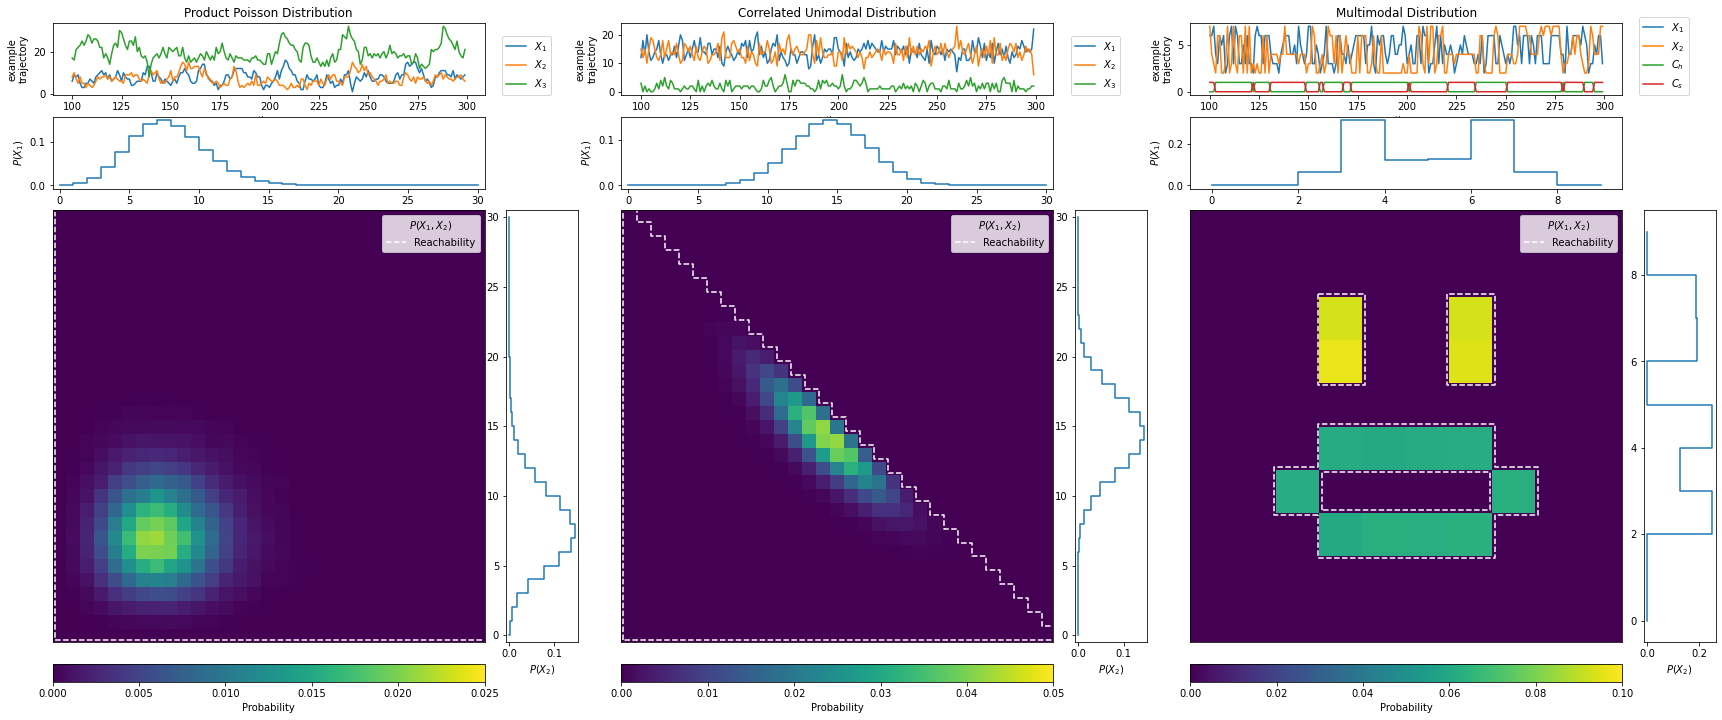

dbCRNs can produce 3 classes of distribution: (Left) __product poisson distributions__ cover the entire integer lattice. (Middle) __unimodal correlated distributions__ are created restricting the stoichiometric compatability class of the CRN. (Right) __complex multimodal distributions__ are created by carefully controlling the reachability class. These CRNs are examined in more detail below.

## 2.1 Example 1: product poisson distribution

This product poisson distribution is generated by the CRN:

## $\emptyset \leftrightharpoons X_1 \quad \emptyset \leftrightharpoons X_2 \quad \emptyset \leftrightharpoons X_3$

It has the cannonical poisson form:

## $\pi(x) = \prod_i \frac{1}{Z_i} e^{-E_i x_i - \log x_i !} \quad Z_i = \sum_{x = 0}^\infty e^{-E_i x_i - \log x_i !} $

Notice that this distribution is in product form meaning all species are independent at equilibrium.

_Changing the energies of each species will only change the mean of that species. Changing the initial condition will not change the distribution because the entire integer lattice is reachable._

## 2.1 Example 1: product poisson distribution

## $\emptyset \leftrightharpoons X_1 \quad \emptyset \leftrightharpoons X_2 \quad \emptyset \leftrightharpoons X_3$

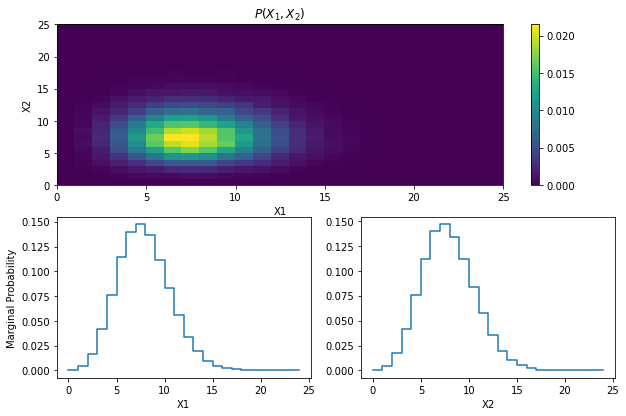

Simulating Complete.


Text(0.5, 0, 'X2')

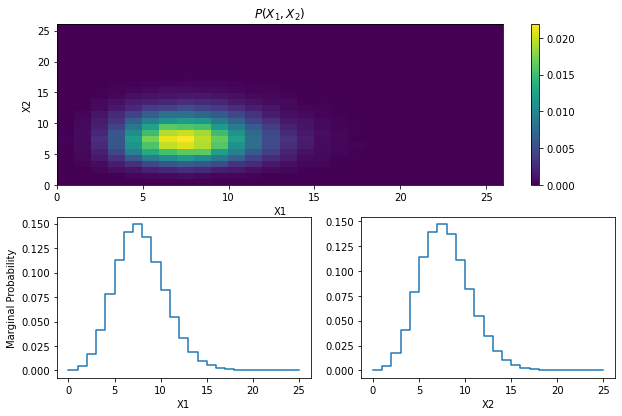

In [11]:
#*********************************************************
#************* Try Changing These Variables! *************
#*********************************************************

#Species' Energies
E1 = -2
E2 = -2
E3 = -3

#initial condition (for all Species)
n = 0


#*********************************************************
#************* Simulation and Plotting Below *************
#*********************************************************

CRN1 = create_product_poisson_crn(E1 = E1, E2 = E2, E3 = E3, n = n)

timepoints = np.arange(0, max_time, 1.)
results1 = py_simulate_model(timepoints, CRN1, stochastic = True, return_dataframe = False); print("Simulating Complete.")
df1 = results1.py_get_dataframe(Model = CRN1)
burn_in = max_time/10.
max_counts1 = int(max(max(df1["X1"]), max(df1["X2"]))+1)
E1_dist_X1_X2 = results1.py_empirical_distribution(species = ["X1", "X2"], start_time = burn_in, Model = CRN1, max_counts = [max_counts1, max_counts1])

E1_marg_X1 = results1.py_empirical_distribution(species = ["X1"], start_time = burn_in, Model = CRN1, max_counts = [max_counts1])
E1_marg_X2 = results1.py_empirical_distribution(species = ["X2"], start_time = burn_in, Model = CRN1, max_counts = [max_counts1])

plt.figure(figsize = (10, 6.5))
plt.subplot(211)
cb = plt.pcolor(E1_dist_X1_X2)
plt.colorbar(cb)
plt.title("$P(X_1, X_2)$")

plt.xlabel("X1")
plt.ylabel("X2")
plt.subplot(223)
bar_marginal(range(len(E1_marg_X1)), E1_marg_X1)
plt.xlabel("X1")
plt.ylabel("Marginal Probability")
plt.subplot(224)
bar_marginal(range(len(E1_marg_X2)), E1_marg_X2)
plt.xlabel("X2")


## 2.2 Example 2: correlated unimodal distribution

This restricted product poisson distribution is generated from the CRN:

### $X_1 \leftrightharpoons X_2 \leftrightharpoons X_3$

Although the equilibrium distribution can also be written in cannonical "poisson" form, the partition function is no longer factorizable but instead must be written as a function of the reachability class $\Omega(x(0))$ which in turn depend on the initial condition. In this case, the reachability class is the stoichiometric subspace. 

#### $\pi(x) = \frac{1}{Z} \prod_i  e^{-E_i x_i - \log x_i !} \quad Z = \sum_{x \in \Omega(x(0))} e^{\sum_i -E_i x_i - \log x_i !} $

Due to the particular reaction network chosen, species will be anti-correlated with eachother.

_Changing the energies of each species will change mean of that species and also induce changes in the means and variances of the other species. Changing the initial condition will change which subset of the integer lattice is reachable also changing the distribution. However, the general shape of this distribution: 3 anti-correlated variables, is robust to changes of the energies and initial condition._

## 2.2 Example 2: correlated unimodal distribution

### $X_1 \leftrightharpoons X_2 \leftrightharpoons X_3$
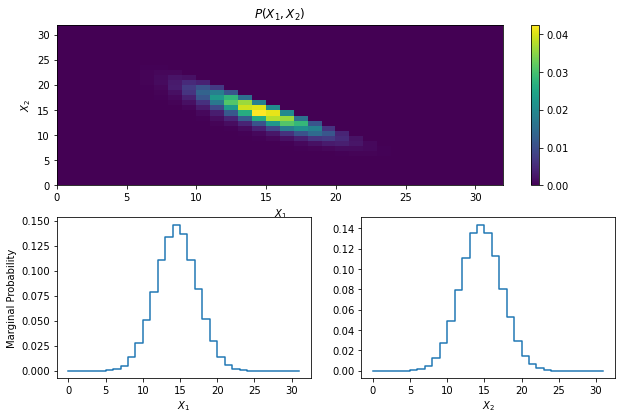

Simulating Complete.


Text(0.5, 0, '$X_2$')

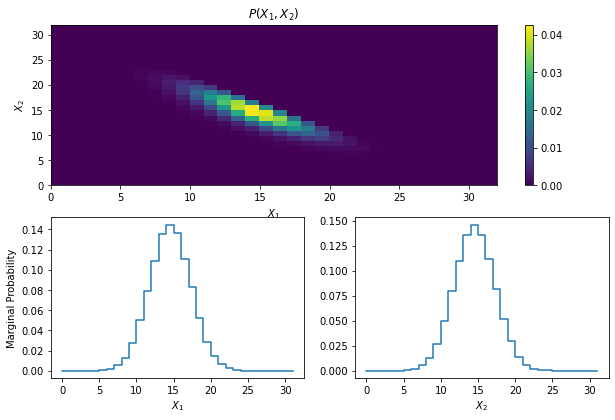

In [12]:
#*********************************************************
#************* Try Changing These Variables! *************
#*********************************************************

#Species Energies
E1 = -2
E2 = -2
E3 = 0

#Maximum Species' count
n = 30


#*********************************************************
#************* Simulation and Plotting Below *************
#*********************************************************

CRN2 = create_restricted_CRN(E1 = E1, E2 = E2, E3 = E3, n = n)

timepoints = np.arange(0, max_time, 1.)
results2 = py_simulate_model(timepoints, CRN2, stochastic = True, return_dataframe = False); print("Simulating Complete.")
df2 = results2.py_get_dataframe(Model = CRN2)
burn_in = max_time/10.
max_counts2 = int(max(max(df2["X1"]), max(df2["X2"]))+1)
E2_dist_X1_X2 = results2.py_empirical_distribution(species = ["X1", "X2"], start_time = burn_in, Model = CRN2, max_counts = [max_counts2, max_counts2])

E2_marg_X1 = results2.py_empirical_distribution(species = ["X1"], start_time = burn_in, Model = CRN2, max_counts = [max_counts2])
E2_marg_X2 = results2.py_empirical_distribution(species = ["X2"], start_time = burn_in, Model = CRN2, max_counts = [max_counts2])

plt.figure(figsize = (10, 6.5))
plt.subplot(211)
cb = plt.pcolor(E2_dist_X1_X2)
plt.colorbar(cb)
plt.title("$P(X_1, X_2)$")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.subplot(223)
bar_marginal(range(len(E2_marg_X1)), E2_marg_X1)
plt.xlabel("$X_1$")
plt.ylabel("Marginal Probability")
plt.subplot(224)
bar_marginal(range(len(E2_marg_X2)), E2_marg_X2)
plt.xlabel("$X_2$")

## 2.3 Example 3: multimodal distribution

The previous example hinted that one species in a dbCRN can strongly influence another species' distribution. This example uses that premise to design a CRN with many hidden species organized into a heirarchical network in order to generate a very specific distribution. This example is a modified from [Capalletti et al. 2019](https://arxiv.org/abs/1810.02854) where dbCRNs are constructed to produce arbitrary distributions with finite support. The CRN is divided into three sets of reactions

Happy Reactions: $C_h + L_h^{(i, j)} + i X_1 + j X_2 \leftrightharpoons C_h + L_h^{(l, m)} + l X_1 + m X_2$

Sad Reactions: $C_s + L_s^{(i, j)} + i X_1 + j X_2 \leftrightharpoons C_s + L_s^{(l, m)} + l X_1 + m X_2$

Transition Reactions: $C_h + L_h^{(i, j)} + i X_1 + j X_2 \leftrightharpoons C_s + L_s^{(l, m)} + l X_1 + m X_2$ 

Here, $C_h$ and $C_s$ are binary "control" species which determine if a happy or sad face is formed. $L_s^{(i, j)}$ and $L_h^{(i, j)}$ denote happy and sad "location" species which represent the $i, j$ pixels seen in each icon. The energies of the locations are counteract the entropies of the $X_1$ and $X_2$ counts in order to exactly produce the distribution. 

Conservation laws: $C_h + C_s = 1 \quad \sum_{i, j} L_s^{i, j}+L_h^{i, j} = 1$
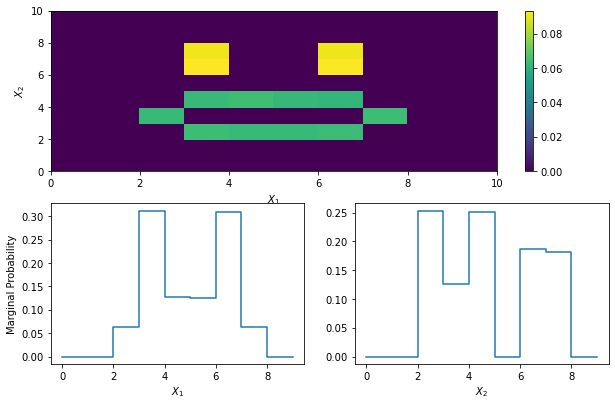

## 2.4 Example 3: multimodal distribution cont.

The energies of $C_h$ and $C_s$ can be tuned to bias the distribution towards happy or sad. Changing $E_1$ and $E_2$ will further skew the distributions. Finally, this construction is reliant on there only being a single location species and a single control species present at any time. If these conservation laws are broken, the reachability class rapidly expands and breaks the control over the equilibrium distribution.

Note that although this CRN uses high order reactions, it could be accureately implemented using only biomolecular reactions for example by iteratively forming molecular complexes which then transition.

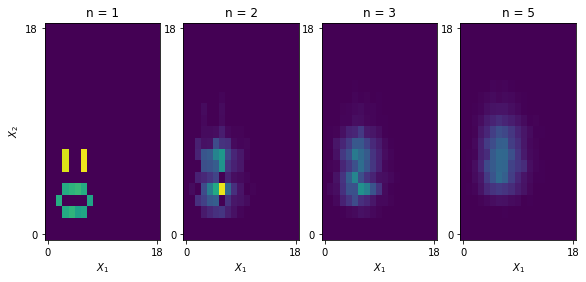

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:138: UserWarning: The following species are uninitialized and their value has been defaulted to 0: P_h_2_4, P_h_2_5, P_h_2_6, P_h_3_2, P_h_3_7, P_h_6_3, P_h_6_6, P_h_7_3, P_h_7_6, P_s_3_7, P_s_4_3, P_s_4_4, P_s_4_5, P_s_4_6, P_s_6_3, P_s_6_6, P_s_7_3, P_s_7_6, 


Simulating Complete.


Text(0.5, 0, '$X_2$')

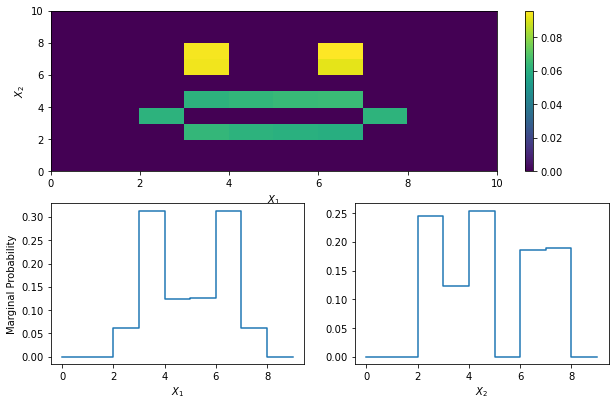

In [13]:
#*********************************************************
#************* Try Changing These Variables! *************
#*********************************************************

#Happy and Sad Energies
E_C_s = 0
E_C_h = 0

#Energies of X1 and X2
E1 = 0
E2 = 0

#The initial pixel and control Species count
n = 1

#*********************************************************
#************* Simulation and Plotting Below *************
#*********************************************************

CRN3 = create_happy_sad_CRN(E_C_s = E_C_s, E_C_h = E_C_s, E1 = E1, E2 = E2, n = n)
timepoints = np.arange(0, max_time, 1.)

results3 = py_simulate_model(timepoints, CRN3, stochastic = True, return_dataframe = False); print("Simulating Complete.")
df3 = results3.py_get_dataframe(Model = CRN3)
burn_in = max_time/10.
max_counts3 = int(max(max(df3["X1"]), max(df3["X2"]))+2)
E3_dist_X1_X2 = results3.py_empirical_distribution(species = ["X1", "X2"], start_time = burn_in, Model = CRN3, max_counts = [max_counts3, max_counts3])
E3_marg_X1 = results3.py_empirical_distribution(species = ["X1"], start_time = burn_in, Model = CRN3, max_counts = [max_counts3])
E3_marg_X2 = results3.py_empirical_distribution(species = ["X2"], start_time = burn_in, Model = CRN3, max_counts = [max_counts3])

plt.figure(figsize = (10, 6.5))
plt.subplot(211)
cb = plt.pcolor(E3_dist_X1_X2.T)
plt.colorbar(cb)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.subplot(223)
bar_marginal(range(len(E3_marg_X1)), E3_marg_X1)
plt.xlabel("$X_1$")
plt.ylabel("Marginal Probability")
plt.subplot(224)
bar_marginal(range(len(E3_marg_X2)), E3_marg_X2)
plt.xlabel("$X_2$")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:138: UserWarning: The following species are uninitialized and their value has been defaulted to 0: P_h_2_4, P_h_2_5, P_h_2_6, P_h_3_2, P_h_3_7, P_h_6_3, P_h_6_6, P_h_7_3, P_h_7_6, P_s_3_7, P_s_4_3, P_s_4_4, P_s_4_5, P_s_4_6, P_s_6_3, P_s_6_6, P_s_7_3, P_s_7_6, 


Simulating Complete n = 1.
Simulating Complete n = 2.
Simulating Complete n = 3.
Simulating Complete n = 5.


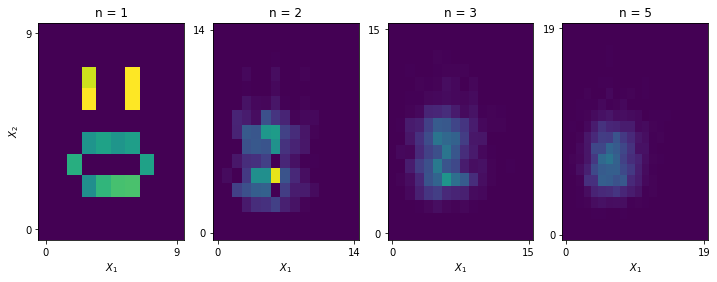

In [14]:
#*********************************************************
#************* Try Changing These Variables! *************
#*********************************************************
#See how the distribution changes with conservation laws
n_list = [1, 2, 3, 5]


#*********************************************************
#************* Simulation and Plotting Below *************
#*********************************************************

#Happy and Sad Energies
E_C_s = 0
E_C_h = 0

#Energies of X1 and X2
E1 = 0
E2 = 0

plt.figure(figsize = (12, 4))

for i, n in enumerate(n_list):
    CRN3 = create_happy_sad_CRN(E_C_s = E_C_s, E_C_h = E_C_s, E1 = E1, E2 = E2, n = n)
    timepoints = np.arange(0, max_time/50, 1.)
    
    results3 = py_simulate_model(timepoints, CRN3, stochastic = True, return_dataframe = False); print(f"Simulating Complete n = {n}.")
    df3 = results3.py_get_dataframe(Model = CRN3)
    burn_in = timepoints[-1]/10.
    max_counts3 = int(max(max(df3["X1"]), max(df3["X2"]))+2)
    E3_dist_X1_X2 = results3.py_empirical_distribution(species = ["X1", "X2"], start_time = burn_in, Model = CRN3, max_counts = [max_counts3, max_counts3])

    
    plt.subplot(100+(len(n_list))*10+i+1)
    plt.title(f"n = {n}")
    cb = plt.pcolor(E3_dist_X1_X2.T, vmin = 0, vmax = .1)
    #
    plt.xticks([.5, max_counts3+.5], [str(0), str(max_counts3)])
    plt.yticks([.5, max_counts3+.5], [str(0), str(max_counts3)])
    plt.xlabel("$X_1$")
    if i == 0:
        plt.ylabel("$X_2$")


# 3.0 Detailed balanced CRNs can perform inference by _clamping_ species to a particular value

We have demonstrated that changing species' energy pushes that species towards a higher or lower value. This form of energy modulation is also a form of inference which we call __clamping__. For example, by decreasing the energy of a species we are making it more favorable and increasing its mean - effectively "holding" that species at a higher value. We have proven that this is equivalent to computing a conditional distribution conditioned upon the "rare event" that a different mean was sampled from the equilibrium distribution.

### Informal Theorem: let $\pi(x)$ be the equilibrium distribution of a dbCRN with energy $E$. Then, let $\pi'(x)$ be the equilibrium distribution of a dbCRN with the same reactions but new energy $E' = E+\Delta$. These two CRNs are related via the [conditional limit theorem](http://staff.ustc.edu.cn/~cgong821/Wiley.Interscience.Elements.of.Information.Theory.Jul.2006.eBook-DDU.pdf): $\pi(x | \mathbb{E}[x] = \mathbb{E}_{\pi'}[x]) = \pi'(x)$

What this means, practically, is that varying the energies of a dbCRN's species is a form of inference and can be used to compute conditional distributions!

## 3.1 Example 1: clamping $X_3$ in a product poisson distribution varies the mean of $X_3$ but does not vary $X_1$ or $X_2$.
CRN: $\emptyset \leftrightharpoons X_1 \quad \quad \emptyset \leftrightharpoons X_2 \quad \quad \emptyset \leftrightharpoons X_3$

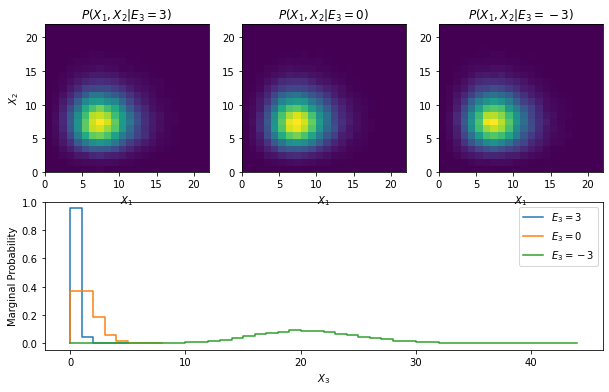

Simulating Complete.
Simulating Complete.
Simulating Complete.


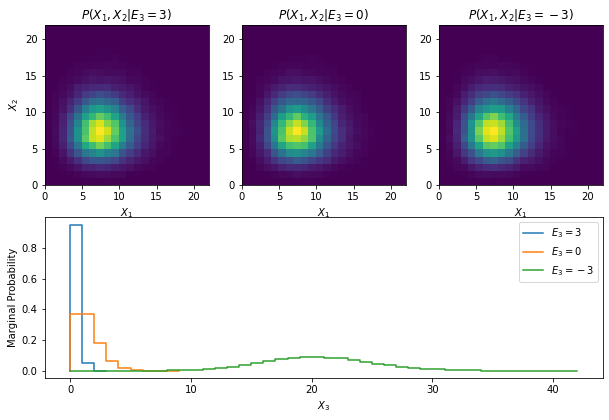

In [15]:
#*********************************************************
#************* Try Changing These Variables! *************
#*********************************************************

#vary the range of values X_3 is clamped to
E3_max = 3
E3_min = -3


#*********************************************************
#************* Simulation and Plotting Below *************
#*********************************************************
E3_list = [E3_max, 0, E3_min]
plt.figure(figsize = (10, 6.5))
axb = plt.subplot(212)
hm_max = 1e10
axes = [plt.subplot(len(E3_list)*10+200+i+1) for i in range(len(E3_list))]
for i, E3 in enumerate(E3_list):
    CRN = create_product_poisson_crn(E3 = E3)
    
    timepoints = np.arange(0, max_time, 1.)
    results = py_simulate_model(timepoints, CRN, stochastic = True, return_dataframe = False); print("Simulating Complete.")
    df = results.py_get_dataframe(Model = CRN)
    max_countsX1 = int(max(df["X1"])+1)
    max_countsX2 = int(max(df["X2"])+1)
    max_countsX3 = int(max(df["X3"])+1)
    hm_max = min([hm_max, max_countsX1, max_countsX2])
    
    burn_in = max_time/10.
    dist_X1_X2 = results.py_empirical_distribution(species = ["X1", "X2"], start_time = burn_in, Model = CRN, max_counts = [max_countsX1, max_countsX2])
    marg_X3 = results.py_empirical_distribution(species = ["X3"], start_time = burn_in, Model = CRN, max_counts = [max_countsX3])

    plt.sca(axes[i])
    plt.pcolormesh(dist_X1_X2)
    plt.title(f"$P(X_1, X_2 | E_3 = {E3})$")
    plt.xlabel("$X_1$")
    if i == 0:
        plt.ylabel("$X_2$")
    
    plt.sca(axb)
    bar_marginal(range(len(marg_X3)), marg_X3, label = f"$E_3={E3}$")

for i in range(len(E3_list)):
    plt.sca(axes[i])
    plt.xlim(0, hm_max)
    plt.ylim(0, hm_max)

plt.sca(axb)
plt.xlabel("$X_3$")
plt.ylabel("Marginal Probability")
plt.legend()

## 3.2 Example 2: clamping $X_3$ in a correlated unimodal distribution varies the mean of $X_3$ which in turn varies the means and variances of $X_1$ and $X_2$.

CRN: $X_1 \leftrightharpoons X_2 \leftrightharpoons X_3$

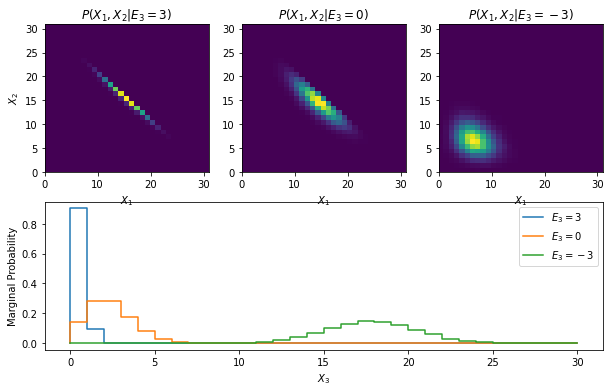

Simulating Complete.
Simulating Complete.
Simulating Complete.


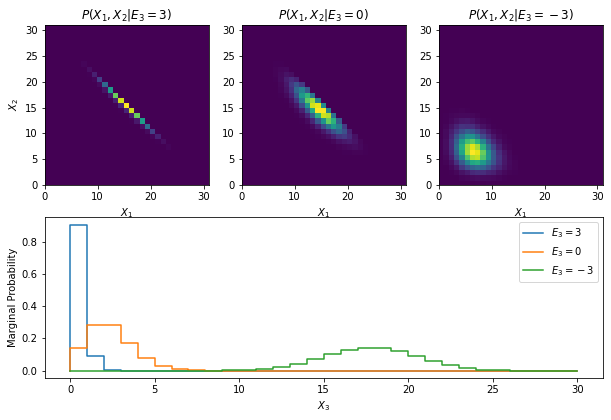

In [16]:
#*********************************************************
#************* Try Changing These Variables! *************
#*********************************************************

#vary the range of values X_3 is clamped to
E3_max = 3
E3_min = -3
n = 30

#*********************************************************
#************* Simulation and Plotting Below *************
#*********************************************************
E_list = [E3_max, 0, E3_min]
plt.figure(figsize = (10, 6.5))
axb = plt.subplot(212)
max_counts2 = n
for i, E3 in enumerate(E_list):
    CRN = create_restricted_CRN(E3 = E3, n = n)
    
    timepoints = np.arange(0, max_time, 1.)
    burn_in = max_time/10.
    
    results = py_simulate_model(timepoints, CRN, stochastic = True, return_dataframe = False); print("Simulating Complete.")
    df2 = results.py_get_dataframe(Model = CRN)
    
    dist_X1_X2 = results.py_empirical_distribution(species = ["X1", "X2"], start_time = burn_in, Model = CRN, max_counts = [max_counts2, max_counts2])    
    max_countsX3 = int(max(df2["X3"])+1)
    
    marg_X3 = results.py_empirical_distribution(species = ["X3"], start_time = burn_in, Model = CRN, max_counts = [max_counts2])
    
    plt.subplot(len(E3_list)*10+200+i+1)
    plt.pcolormesh(dist_X1_X2)
    plt.title(f"$P(X_1, X_2 | E_3 = {E3})$")
    plt.xlabel("$X_1$")
    if i == 0:
        plt.ylabel("$X_2$")
    
    plt.sca(axb)
    bar_marginal(range(len(marg_X3)), marg_X3, label = f"$E_3={E3}$")
    
plt.xlabel("$X_3$")
plt.ylabel("Marginal Probability")
plt.legend()

## 3.3 Example 3: clamping $C_h$ in a multimodal distribution pushes the binary species $C_h$ and $C_s$ to be ON or OFF causing the distribution to switch from _sad_ to _happy_.

CRN: See previous slide.

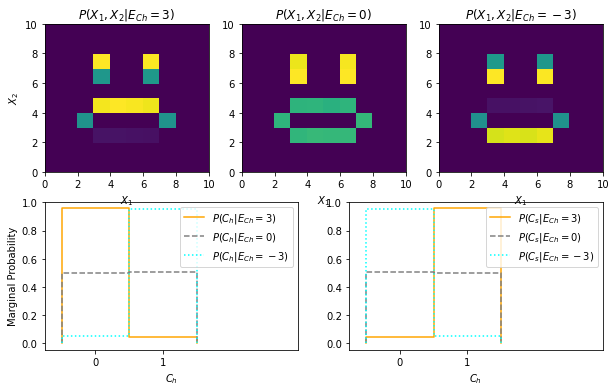

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:138: UserWarning: The following species are uninitialized and their value has been defaulted to 0: P_h_2_4, P_h_2_5, P_h_2_6, P_h_3_2, P_h_3_7, P_h_6_3, P_h_6_6, P_h_7_3, P_h_7_6, P_s_3_7, P_s_4_3, P_s_4_4, P_s_4_5, P_s_4_6, P_s_6_3, P_s_6_6, P_s_7_3, P_s_7_6, 


Simulating Complete.
Simulating Complete.
Simulating Complete.


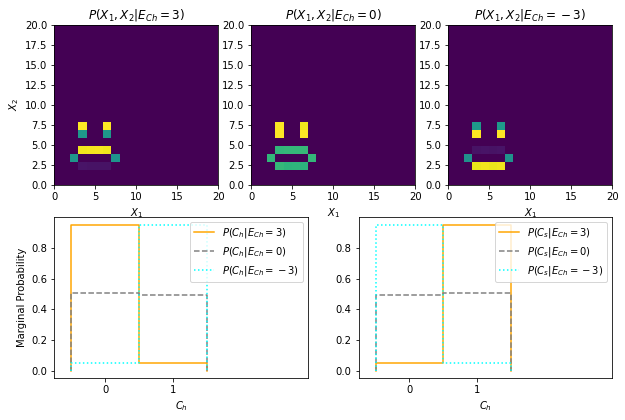

In [17]:
#*********************************************************
#************* Try Changing These Variables! *************
#*********************************************************

#vary the range of values C_h is clamped to
E3_max = 3
E3_min = -3


#*********************************************************
#************* Simulation and Plotting Below *************
#*********************************************************
plt.figure(figsize = (10, 6.5))
E_list = [E3_max, 0, E3_min]
color_list = ["orange", "gray", "cyan"]
ls_list = ["-", "--", ":"]
axb1 = plt.subplot(223)
axb2 = plt.subplot(224)
for i, E3 in enumerate(E_list):
    CRN = create_happy_sad_CRN(E_C_h = E3)
    
    timepoints = np.arange(0, max_time, 1.)
    results = py_simulate_model(timepoints, CRN, stochastic = True, return_dataframe = False); print("Simulating Complete.")
    burn_in = max_time/10.
    dist_X1_X2 = results.py_empirical_distribution(species = ["X1", "X2"], start_time = burn_in, Model = CRN, max_counts = [max_counts3, max_counts3])    
    marg_Ch = results.py_empirical_distribution(species = ["C_h"], start_time = burn_in, Model = CRN, max_counts = [2])
    marg_Cs = results.py_empirical_distribution(species = ["C_s"], start_time = burn_in, Model = CRN, max_counts = [2])
    
    plt.subplot(len(E3_list)*10+200+i+1)
    plt.title("$P(X_1, X_2 | E_{Ch} = "+str(E3)+")$")
    plt.pcolormesh(dist_X1_X2.T)
    
    plt.xlabel("$X_1$")
    if i == 0:
        plt.ylabel("$X_2$")
    
    plt.sca(axb1)
    bar_marginal(range(len(marg_Ch)), marg_Ch, color = color_list[i], label = "$P(C_h | E_{Ch} = "+str(E3)+")$", ls = ls_list[i])
    plt.sca(axb2)
    bar_marginal(range(len(marg_Cs)), marg_Cs, color = color_list[i], label = "$P(C_s | E_{Ch} = "+str(E3)+")$", ls = ls_list[i])

plt.sca(axb1)
plt.xlabel("$C_h$")
plt.ylabel("Marginal Probability")
plt.xticks([.5, 1.5], ["0", "1"])
plt.xlim(-.25, 3.5)
plt.legend()
plt.sca(axb2)
plt.xlabel("$C_h$")
plt.xticks([.5, 1.5], ["0", "1"])
plt.xlim(-.25, 3.5)
plt.legend()

## 3.4 Clamping with potential chemostats

What does it mean to change the energy of a species? Evolutionarily, changes in sequences (nucleic, peptide etc.) could modulate binding energies, providing a connection between mathematical inference and evolution.

There are also more immediate ways to control the species' energies. One implementation comes from coupling each species $X_i$ to an external chemical potential $P_i$ such that whenever $X_i$ is changed in any reaction, $P_i$ is changed with it.

#### Informal Theorem: Let $\pi_P(x)$ be the equilibrium distribution of a dbCRN where the species $X_i$ have energy $E_i$ and are coupled to a potential species $P_i$ with energy $E^P_i$. Let $\pi'(x)$ be the equilibrium distribution of a  dbCRN without potential Species where $X_i$ has energy $E'_i = E_i + \Delta_i = E_i + E^P_i \log [P_i]$ and $[P_i]$ is the concentration of $P_i$ in a very large volume connected to the system. Then, in the limit $p_i \to \infty$, $\pi_P(x) = \pi'(x)$. 

In chemistry and physics, the term $E^P_i + \log [P_i]$ is commonly known as the chemical potential $\mu$. This illustrates that inference via clamping via changing the energies of a detailed balanced CRN can be accomplished by modulating a chemical potential.

## 3.5 Example: potential claming a product poisson

#### $\emptyset \leftrightharpoons X$ with $G[X] = E_X + \Delta \quad \approx \quad \emptyset \leftrightharpoons X + P$  with $G[X] = E_X$, $G[P] = 0$ and $P_0 = e^\Delta$ 

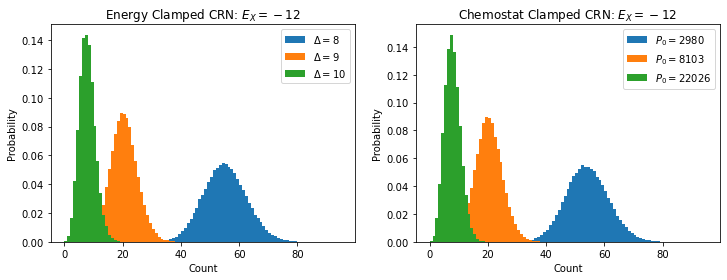

Simulating Complete.
Simulating Complete.


Text(0, 0.5, 'Probability')

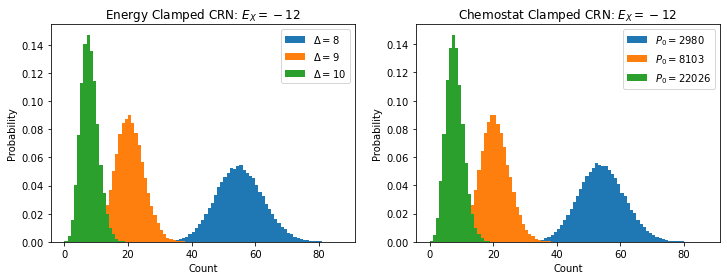

In [18]:
#*********************************************************
#************* Try Changing These Variables! *************
#*********************************************************

#Base Energy
E_X = -12

#Clamped Energy
deltas = [8, 9, 10]

#NOTE: as delta becomes small, the potential chemostat becomes an approximation to a more complex stochastic process.

#*********************************************************
#************* Simulation and Plotting Below *************
#*********************************************************

species = ["X1", "X2", "X3"]
E = {species[i]:deltas[i]+E_X for i in range(3)}

reactions = db_rxns([], ["X1"], E)+db_rxns([], ["X2"], E)+db_rxns([], ["X3"], E)
CRN = Model(species = species, reactions = reactions, initial_condition_dict = {s:0 for s in species})

timepoints = np.arange(0, max_time, 1.)
R = py_simulate_model(timepoints, CRN, stochastic = True); print("Simulating Complete.")
max_count = int(np.max([R["X1"].max(), R["X2"].max(), R["X3"].max()])+1)

species_P = species + ["P1", "P2", "P3"]
E_P = {s:E_X*("X" in s) for s in species_P}
reactions_P = db_rxns([], ["X1", "P1"], E_P)+db_rxns([], ["X2", "P2"], E_P)+db_rxns([], ["X3", "P3"], E_P)
x0 = {s:0 for s in species}
x0["P1"] = int(np.exp(deltas[0]))
x0["P2"] = int(np.exp(deltas[1]))
x0["P3"] = int(np.exp(deltas[2]))
    
CRN_P = Model(species = species_P, reactions = reactions_P, initial_condition_dict = x0)
R_P = py_simulate_model(timepoints, CRN_P, stochastic = True); print("Simulating Complete.")


plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.title(f"Energy Clamped CRN: $E_X = {E_X}$")
plt.hist(R["X1"].to_numpy(), bins = max_count, range = (0, max_count), label = f"$\Delta={deltas[0]}$", density = True)
plt.hist(R["X2"].to_numpy(), bins = max_count, range = (0, max_count), label = f"$\Delta={deltas[1]}$", density = True)
plt.hist(R["X3"].to_numpy(), bins = max_count, range = (0, max_count), label = f"$\Delta={deltas[2]}$", density = True)
plt.legend()
plt.xlabel('Count')
plt.ylabel("Probability")

plt.subplot(122)
plt.title(f"Chemostat Clamped CRN: $E_X = {E_X}$")
plt.hist(R_P["X1"].to_numpy(), bins = max_count, range = (0, max_count), label = f"$P_0={x0['P1']}$", density = True)
plt.hist(R_P["X2"].to_numpy(), bins = max_count, range = (0, max_count), label = f"$P_0={x0['P2']}$", density = True)
plt.hist(R_P["X3"].to_numpy(), bins = max_count, range = (0, max_count), label = f"$P_0={x0['P3']}$", density = True);
plt.legend()
plt.xlabel('Count')
plt.ylabel("Probability")

# 4.0 Learning the potential chemostat concentrations
Here, we show a (non detailed balanced) CRN which is capable of tuning the potential chemostat concentrations $[P_i]$ until $X_i$ have the desired mean. This is accomplished by augmenting any dbCRN with potential chemostats with two learning reactions per chemostat resulting in a [hybrid bulk / stochastic model](https://aip.scitation.org/doi/full/10.1063/1.2428297?casa_token=uffmlStyADkAAAAA%3A21ySKYWZCYppaltb_MqA14JFIleNVrSi_N3tXG744S6e1Kje6CSOBW9XLyujqAQND4ea4y4-FA). 

### $P_i + Q_i \to Q_i \quad \quad P_i + X_i \to 2 P_i + X_i$

Here, $Q_i$ are external species vary according to the distribution $\psi$.

#### Informal Theorem: If these two reactions occur much more slowly than the equilibration of the $X_i$ species, then it can be shown that at steady state: $\frac{d P_i}{dt} = 0 \implies \mathbb{E}_\pi(x_i) = \mathbb{E}_\psi[q_i]$.

Convergence of a similar model has been proven for a CRN EM algorithm in [Virinchi et al. 2018](https://link.springer.com/chapter/10.1007/978-3-030-00030-1_12).

## 4.1 Example 1: Learning the mean of a product poisson
Chemostatted dbCRN reactions: $\emptyset \leftrightharpoons X + P$

Learning reactions: $P + Q \overset{k}{\to} Q \quad \quad P + X \overset{k}{\to} 2 P + X$
 
Although the above proof assumes $P$ is a deterministic species, we simulate this CRN stochastically to avoid hybrid simulation.
 
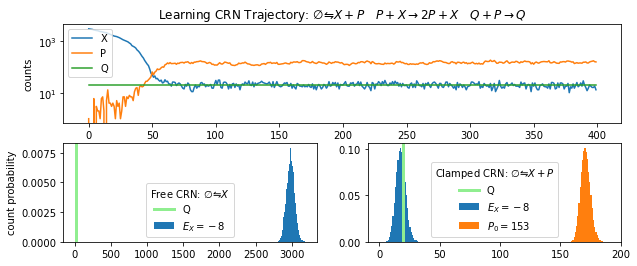
 
Notice that $X$ fluctates around $Q$. 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: The following species are uninitialized and their value has been defaulted to 0: X1, X2, X3, 


Simulating Complete.
Simulating Complete.
Simulating Complete.


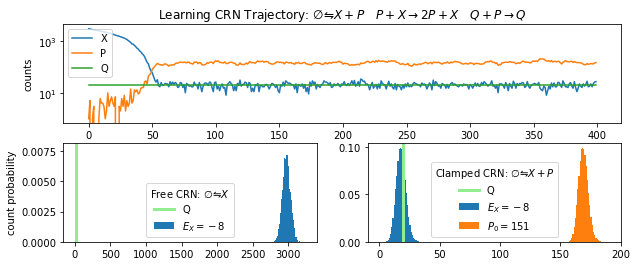

In [19]:
#*********************************************************
#************* Try Changing These Variables! *************
#*********************************************************

#Target Mean
Q = 20

#Initial Potential Species
P0 = 1

#Energies
E_P = 0
E_X = -8

#learning rate
k_learning = .01

learning_time = 400

#*********************************************************
#************* Simulation and Plotting Below *************
#*********************************************************
E = {"X":E_X, "P":E_P, "Q":0}

#Free CRN
x0_free = {"X":int(np.exp(-E_X)), "Q":Q, "P":P0}
CRN_free = Model(species = species, reactions = db_rxns([], ["X"], E), initial_condition_dict = x0_free)
timepoints = np.arange(0, max_time, 1.)
R_free = py_simulate_model(timepoints, CRN_free, stochastic = True, return_dataframe = True); print("Simulating Complete.")


#Learning CRN
species = ["X", "P", "Q"]
reactions = db_rxns([], ["X", "P"], E) #db Rection
reactions += chemostat_reactions(["X", "P"], ["X", "P", "P"], kf = k_learning, kr = 0) #learning reaction 1
reactions += chemostat_reactions(["Q", "P"], ["Q"], kf = k_learning, kr = 0) #learning reaction 2
x0_LP = {"X":np.mean(R_free["X"].to_numpy()), "Q":Q, "P":P0}

CRN_LP = Model(species = species, reactions = reactions, initial_condition_dict = x0_LP)
timepoints = np.arange(0, learning_time, 1.)
results_LP = py_simulate_model(timepoints, CRN_LP, stochastic = True, return_dataframe = True); print("Simulating Complete.")

#Chemostat Clamped CRN
timepoints = np.arange(0, max_time, 1.)
Pclamped = int(np.mean(results_LP["P"].to_numpy()[-int(learning_time/10):]))

x0_clamped = {"X":0, "Q":Q, "P":Pclamped}
CRN_clamped = Model(species = species, reactions = db_rxns([], ["X", "P"], E), initial_condition_dict = x0_clamped)
R_clamped = py_simulate_model(timepoints, CRN_clamped, stochastic = True, return_dataframe = True); print("Simulating Complete.")

plt.figure(figsize = (10, 4))
plt.subplot(211)
plt.title('Learning CRN Trajectory: $\emptyset \leftrightharpoons X + P \quad P + X \\rightarrow 2P + X \quad Q + P \\rightarrow Q$')
plt.plot(results_LP["time"], results_LP["X"], label = "X")
plt.plot(results_LP["time"], results_LP["P"], label = "P")
plt.plot(results_LP["time"], results_LP["Q"], label = "Q")
plt.legend()
plt.ylabel("counts")
plt.yscale('log')


plt.subplot(223)
bins = int(max(R_free["X"].to_numpy())+1)
plt.hist(R_free["X"].to_numpy()[int(len(timepoints)/2):], bins = bins, range = (0, bins), density = True, label = f"$E_X = {E_X}$");
plt.axvline(Q, label = "Q", lw = 3, color = 'lightgreen')
plt.ylabel("count probability")
plt.legend(title = 'Free CRN: $\emptyset \leftrightharpoons X$')


plt.subplot(224)
binsX = int(max(R_clamped["X"].to_numpy())+1)
plt.hist(R_clamped["X"].to_numpy()[int(len(timepoints)/2):], bins = binsX, range = (0, binsX), density = True, label = f"$E_X = {E_X}$");

binsP = int(max(R_clamped["P"].to_numpy())+1)
plt.hist(R_clamped["P"].to_numpy()[int(len(timepoints)/2):], bins = binsP, range = (0, binsP), density = True, label = f"$P_0 = {Pclamped}$");

plt.axvline(Q, label = "Q", lw = 3, color = 'lightgreen')
plt.legend(title = 'Clamped CRN: $\emptyset \leftrightharpoons X + P$')

## 4.2 An XOR Chemical Boltzmann Machine (CBM)

A Chemical Boltzmann Machine is a dbCRN which exactly implements a Boltzmann Machine:

### $X^0 + Y^0 \leftrightharpoons X^1 + Y^0$
### $X^0 + Y^0 \leftrightharpoons X^0 + Y^1$
### $X^1 + Y^0 + W^0 \leftrightharpoons X^1 + Y^1 + W^1$
### $X^0 + Y^1 + W^0 \leftrightharpoons X^1 + Y^1 + W^1$

And an initial condition such that $x^0 + x^1 = 1 \quad y^0 + y^1 = 1 \quad w^0 + w^1 = 1 \quad (x^1)(y^1) = w^1$

## 4.3 Learning An XOR chemical boltzmann machine (CBM)

By connecting the XOR CRN to 6 chemostats (one for each species) and 12 learning reactions, we get a non-detailed balanced CRN (full CRN shown below) which dynamically adjusts the potential species until the distribtion $\pi(x | P) = Q$.

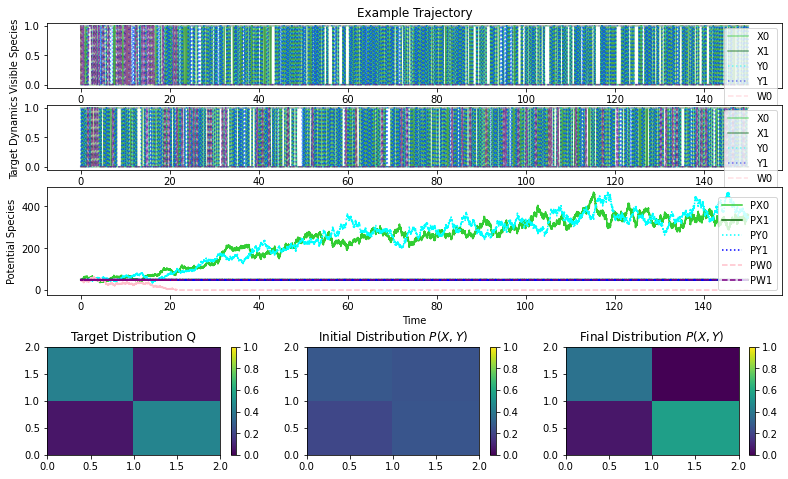



## 4.4 The XOR CBM coupled to learning chemostats

Fast Chemostatted CBM Reactions:

$X^0 + Y^0 + P_X^0 \leftrightharpoons X^1 + Y^0 + P_X^1$

$X^0 + Y^0 + P_Y^0 \leftrightharpoons X^0 + Y^1 + P_Y^1$

$X^1 + Y^0 + W^0 + P_Y^0 + P_W^0 \leftrightharpoons X^1 + Y^1 + W^1 + P_Y^1 + P_W^1$

$X^0 + Y^1 + W^0 + P_X^0 + P_W^0 \leftrightharpoons X^1 + Y^1 + W^1 + P_X^1 + P_W^1$

Slow Learning Reactions:

$X^0 + P_X^0 \to X^0 + 2 P_X^0 \quad \quad Q_X^0 + P_X^0 \to Q_X^0$

$X^1 + P_X^1 \to X^1 + 2 P_X^1 \quad \quad Q_X^1 + P_X^1 \to Q_X^1$

$Y^0 + P_Y^0 \to Y^0 + 2 P_Y^0 \quad \quad Q_Y^0 + P_Y^0 \to Q_Y^0$

$Y^1 + P_Y^1 \to P_Y^1 + 2 P_Y^1 \quad \quad Q_Y^1 + P_Y^1 \to Q_Y^1$


$W^0 + P_W^0 \to W^0 + 2 P_W^0 \quad \quad Q_W^0 + P_W^0 \to Q_W^0$

$W^1 + P_W^1 \to W^1 + 2 P_W^1 \quad \quad Q_W^1 + P_W^1 \to Q_W^1$

In [20]:
#*********************************************************
#************* Try Changing These Variables! *************
#*********************************************************


#WARNING: separation of timescales is essential for this CRN to function. 
# k_db ~= k_Q >> K_learn is essential for convergence
# k_r << k_learn is essential for accurate learning

max_time = 150.0 #Learning Time
EP = 0 #Potenial Species Energy
k_db = 10 #Speed of the Model Reactions
k_Q = 100 #Speed of the Enivorment Reactions
k_learn = 1.0 #Learning Rate
k_r = 0 #Makes the learning reactions reversible


#*********************************************************
#******************* Simulation Below ********************
#*********************************************************

CRN_learning = learning_XOR_CRN(EP = EP, P0 = 50, k = k_learn, kr = 0, k_Q = k_Q, k_db = k_db)

#Create XOR CRN
x00 = CRN_learning.get_species_dictionary()

CRN_learning.set_species(x00)


dt = max_time/20000
timepoints = np.arange(0.0, max_time, dt)
burn_in = max_time/50

#Learning CRN Simulation
results_learning = py_simulate_model(timepoints, CRN_learning, stochastic = True, return_dataframe = False); print("Learning Simulating Complete.")
dist_Q = results_learning.py_empirical_distribution(species = ["QX1", "QY1"], start_time = burn_in, Model = CRN_learning, max_counts = [1, 1])
distXY_list = []
DKL_list = []
dkl_points = 100
for i in range(dkl_points):
    t0 = i * max_time/dkl_points
    tf = (i+1)*max_time/dkl_points-dt
    dist = results_learning.py_empirical_distribution(species = ["X1", "Y1"], start_time = t0, final_time = tf, Model = CRN_learning, max_counts = [1, 1])
    distXY_list.append(dist)
    
R = results_learning.py_get_result()

#Create final XOR CRN
indPX0 = CRN_learning.get_species_index("PX0")
indPX1 = CRN_learning.get_species_index("PX1")
indPY0 = CRN_learning.get_species_index("PY0")
indPY1 = CRN_learning.get_species_index("PY1")
indPW0 = CRN_learning.get_species_index("PW0")
indPW1 = CRN_learning.get_species_index("PW1")

indX0 = CRN_learning.get_species_index("X0")
indX1 = CRN_learning.get_species_index("X1")
indY0 = CRN_learning.get_species_index("Y0")
indY1 = CRN_learning.get_species_index("Y1")
indW0 = CRN_learning.get_species_index("W0")
indW1 = CRN_learning.get_species_index("W1")

indQX0 = CRN_learning.get_species_index("QX0")
indQX1 = CRN_learning.get_species_index("QX1")
indQY0 = CRN_learning.get_species_index("QY0")
indQY1 = CRN_learning.get_species_index("QY1")
indQW0 = CRN_learning.get_species_index("QW0")
indQW1 = CRN_learning.get_species_index("QW1")

Learning Simulating Complete.


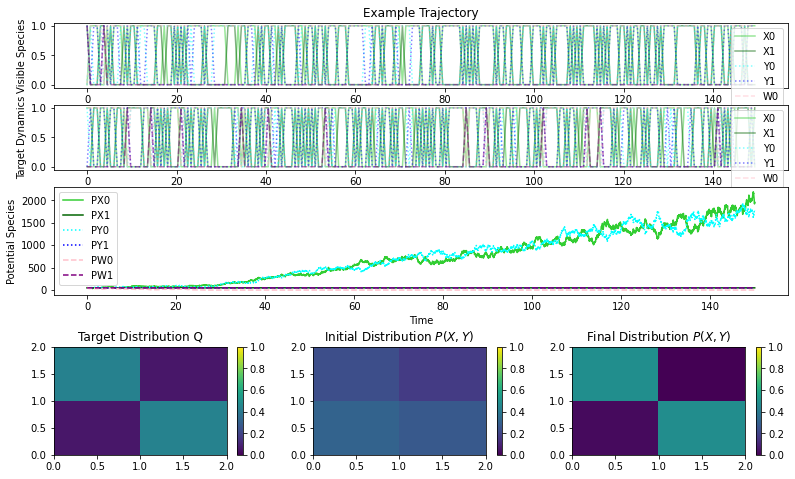

In [21]:
#*********************************************************
#********************* Plotting Below ********************
#*********************************************************

plt.figure(figsize = (12, 6))
w0 = .05
w1 = .85
w2 = .25
h0 = .04
h2 = .25
h1 = .15

ax1 = plt.axes((w0, 6*h0 + 2*h2+h1, w1, h1))
ax2 = plt.axes((w0, 5*h0 + 2*h2, w1, h1))
ax3 = plt.axes((w0, 4*h0 + h2, w1, h2))
ax4a = plt.axes((w0, h0, w2, h2))
ax4b = plt.axes((2*w0+w2, h0, w2, h2))
ax4c = plt.axes((3*w0+2*w2, h0, w2, h2))

        
plt.sca(ax1)
plt.title("Example Trajectory")
plt.ylabel("Visible Species")
plt.plot(timepoints[::100], R[:, indX0][::100], color = "limegreen", label = "X0", alpha = .5)
plt.plot(timepoints[::100], R[:, indX1][::100], color = "darkgreen", label = "X1", alpha = .5)

plt.plot(timepoints[::100], R[:, indY0][::100], ":", color = "cyan", label = "Y0", alpha = .5)
plt.plot(timepoints[::100], R[:, indY1][::100], ":", color = "blue", label = "Y1", alpha = .5)

plt.plot(timepoints[::100], R[:, indW0][::100], "--", color = "pink", label = "W0", alpha = .5)
plt.plot(timepoints[::100], R[:, indW1][::100], "--", color = "purple", label = "W1", alpha = .5)
plt.legend()

plt.sca(ax2)
plt.ylabel("Target Dynamics")
plt.plot(timepoints[::100], R[:, indQX0][::100], color = "limegreen", label = "X0", alpha = .5)
plt.plot(timepoints[::100], R[:, indQX1][::100], color = "darkgreen", label = "X1", alpha = .5)

plt.plot(timepoints[::100], R[:, indQY0][::100], ":", color = "cyan", label = "Y0", alpha = .5)
plt.plot(timepoints[::100], R[:, indQY1][::100], ":", color = "blue", label = "Y1", alpha = .5)

plt.plot(timepoints[::100], R[:, indQW0][::100], "--", color = "pink", label = "W0", alpha = .5)
plt.plot(timepoints[::100], R[:, indQW1][::100], "--", color = "purple", label = "W1", alpha = .5)
plt.legend()


plt.sca(ax3)
plt.ylabel("Potential Species")
plt.xlabel("Time")

plt.plot(timepoints, R[:, indPX0], color = "limegreen", label = "PX0")
plt.plot(timepoints, R[:, indPX1], color = "darkgreen", label = "PX1")

plt.plot(timepoints, R[:, indPY0], ":", color = "cyan", label = "PY0")
plt.plot(timepoints, R[:, indPY1], ":", color = "blue", label = "PY1")

plt.plot(timepoints, R[:, indPW0], "--", color = "pink", label = "PW0")
plt.plot(timepoints, R[:, indPW1], "--", color = "purple", label = "PW1")
plt.legend()

plt.sca(ax4a)
plt.title('Target Distribution Q')
cb = plt.pcolor(dist_Q, vmin = 0, vmax = 1)
plt.colorbar(cb)

plt.sca(ax4b)
plt.title('Initial Distribution $P(X, Y)$')
cb = plt.pcolor(distXY_list[0], vmin = 0, vmax = 1)
plt.colorbar(cb)


#Run a simulation at a second time point
plt.sca(ax4c)
ind = -1
x0f = dict(x00)
x0f["PX0"] = R[ind, indPX0]
x0f["PX1"] = R[ind, indPX1]
x0f["PY0"] = R[ind, indPY0]
x0f["PY1"] = R[ind, indPY1]
x0f["PW0"] = R[ind, indPW0]
x0f["PW1"] = R[ind, indPW1]
#CRN_learned.set_species(x0f)
#resultsf = py_simulate_model(timepoints_xor, CRN_learned, stochastic = True, return_dataframe = False); print("Simulating Complete.")
#dist_XYf = resultsf.py_empirical_distribution(species = ["X1", "Y1"], start_time = burn_in, Model = CRN_learned, max_counts = [1, 1])

plt.title('Final Distribution $P(X, Y)$')
cb = plt.pcolor(distXY_list[-8], vmin = 0, vmax = 1)
plt.colorbar(cb)



## 4.5 The dynamics of learning

$P_i + Q_i \overset{k}{\to} Q_i \quad \quad P_i + X_i \overset{k}{\to} 2 P_i + X_i$

Can be written as ODEs:

$\frac{d P_i}{dt} = k(\mathbb{E}_{\pi^P}[s_i] - \mathbb{E}_{\psi}[q_i]) \quad \implies \quad P_i(t) = Ce^{k(\mathbb{E}_{\pi^P}[s_i] - \mathbb{E}_{\psi}[q_i])}$

Observations:
* Initially, learning is exponential when $s_i$ does not match $q_i$ then learning slows rapidly.
* Blow up only occurs if $\mathbb{E}_\psi[Q_i] \leq \min_{\Omega(x(0))} x_i$  because $\lim_{p_i \to \infty} = \min_{\Omega(x(0))} x_i$. 

# 5.0 Thermodynamic Lower Bounds

Clamping with potential chemostats allows for a thermodynamic treatment of inference and learning. First, we notice that clamping and learning are fundamentally the same process: tuning the energes $E$ of a dbCRN. We vary the volume $V_i$ of an ideal dilute solution of $P_i$ in order to adjust the concentrations $[P_i]$ which in turn vary species' energies via the chemical potential $\mu_i$. This allows classical thermodynamics of ideal gasses to be applied to clamping via inference. This analysis is closely inspired by [Ouldridge et al. 2018](https://arxiv.org/abs/1812.09572).

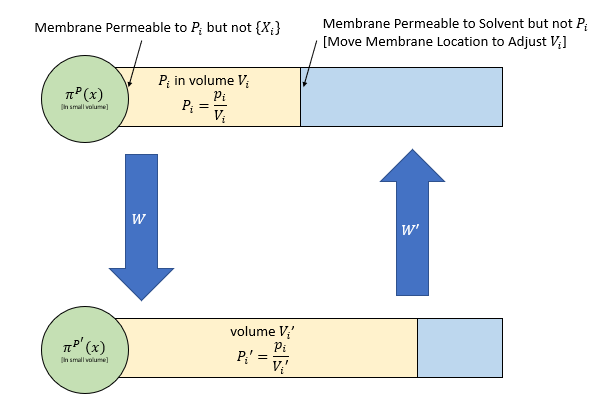

## 5.1 Reversible case

Consider a reversible (quasi-static) transition:

### $(V, \pi^P(x)) \implies (V', \pi^{P'}(x))$

### Informal Theorem: The CRN is always at equilibrium relative to the potential chemostats as the volume is changed (very slowly). The work needed for this process is just the amount needed to compress/expand pistons containing the Species $P_i$. Furthermore, no energy will be dissipated by this process assuming perfect pistons.

_This means learning and inference can be energetically free if done slowly enough._

## 5.2 Irreversible case
Next consider an irreversible transition where the volume is varied instaneously (and in particular, faster than the CRN can equilibrate). Assuming ideal pistons, membranes, etc. The transitions now take the form:

### $(V, \pi^P(x)) \implies (V', \pi^{P}(x)) \implies (V', \pi^{P'}(x))$

### Informal Theorem: The CRN is not at equilibrium relative to the potential chemostats after the volume is changed (very quickly). The work needed for this process is just the amount needed to compress/expand pistons containing the Species $P_i$. However, in this case energy will be dissipated due to the equilibration of the CRN from $(V', \pi^P) \implies (V', \pi^{P'})$. This dissipation is equal to the Relative Entropy $D(\pi^P || \pi^{P'})$. 

_This means learning and inference, when conducted quickly, are harder for distributions farther from the model's current equilibrium._

## 6.0 Thermodynamics of the Learning CRN

In order to analyze the learning CRN thermodynamically, we must first make it reversible. Conceptually, this means the learning reactions are implicitly powered by infinite reservoirs of some fuel molecule.

$P_i + Q_i \underset{\epsilon}{\overset{k}{\rightleftarrows}} Q_i \quad \quad P_i + X_i \underset{\epsilon}{\overset{k}{\rightleftarrows}} 2 P_i + X_i$

Which can be modeled as the ODE:

$\frac{d[P_i]}{dt} = [P_i] \mathbb{E}_{\pi^P}[s_i](k - \epsilon [P_i]) - \mathbb{E}_{\psi}[q_i](k [P_i] - \epsilon) = J_i^S - J_i^Q$

### Steady state occurs when $J_i^Q = J_i^S$

## 6.1 Steady State Error:

### $\textrm{% Error} = | \frac{\mathbb{E}_{\psi}[q_i] - \mathbb{E}_{\pi^P}[s_i]}{\mathbb{E}_{\psi}[q_i]} | =  | \frac{\epsilon (1 - [P_i]^2)}{[P_i](k - \epsilon [P_i])} |$

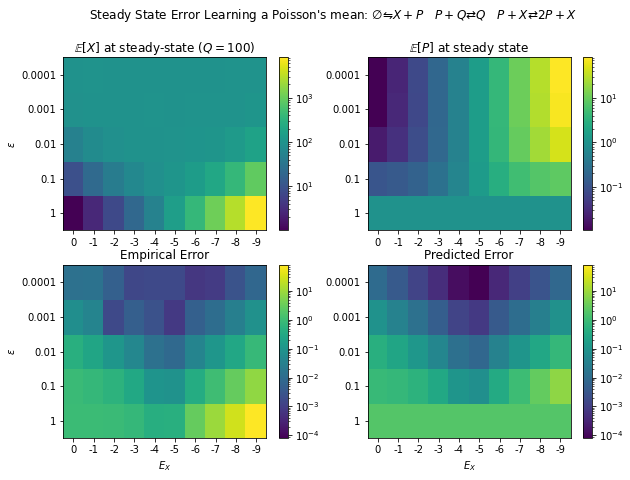

In [ ]:
#*********************************************************
#************* Try Changing These Variables! *************
#*********************************************************

#Warning! This simulation can take a long time if many different Energy-Epsilon Combinations are tried
#         and/or long simulation times are used to get accurate statistics.

epsilon_list = [10**(-i) for i in range(5)] #Epsilon Values
energy_list = [-i for i in range(10)] #Energy Values of the initial (untrained) CRN
timepoints = np.linspace(0.0, 1000.0, 100000) #Simulation time

E_P = 0 #Energy of the Potential Species
k_learning = 1.0 #Learning Rate: making this too large can lead to blow-up
Q = 100 #Target Species
P0 = 0 #Initial Potential Species

#*********************************************************
#************* Simulation and Plotting Below *************
#*********************************************************
import matplotlib

N = len(epsilon_list)
M = len(energy_list)

meanX = np.zeros((N, M))
meanP = np.zeros((N, M))

for i, kr in enumerate(epsilon_list):
    for j, E_X in enumerate(energy_list):
        print(f"Simulating (e, Ex) = {(kr, E_X)}...", end = "")
        E = {"X":E_X, "Q":Q, "P":E_P}
        #Learning CRN
        species = ["X", "P", "Q"]
        reactions = db_rxns([], ["X", "P"], E, k = 100) #db Rection
        reactions += chemostat_reactions(["X", "P"], ["X", "P", "P"], kf = k_learning, kr = kr) #learning reaction 1
        reactions += chemostat_reactions(["Q", "P"], ["Q"], kf = k_learning, kr = kr) #learning reaction 2
        x0 = {"X":np.exp(-E_X), "Q":Q, "P":P0}
        
        CRN = Model(species = species, reactions = reactions, initial_condition_dict = x0)
        
        R = py_simulate_model(timepoints, CRN, stochastic = True, return_dataframe = True)
        
        meanX[i, j] = np.mean(R["X"].to_numpy()[int(len(timepoints)/2):])
        meanP[i, j] = np.mean(R["P"].to_numpy()[int(len(timepoints)/2):])
        
        #plt.plot(R["time"], R["X"], label = f"$E_X={E_X} \epsilon={kr}$")

plt.figure(figsize = (10, 7))

crn_txt = 'Steady State Error Learning a Poisson\'s mean: $\\emptyset \\leftrightharpoons X + P \\quad P + Q \\rightleftarrows Q \\quad P + X \\rightleftarrows 2 P + X$'

plt.suptitle(crn_txt)

plt.subplot(221)
plt.title("$\mathbb{E}[X]$ at steady-state ($Q = "+str(Q)+"$)")
cb = plt.pcolormesh(meanX, norm=matplotlib.colors.LogNorm(vmin=meanX.min(), vmax=meanX.max()))
plt.colorbar(cb)
plt.yticks(np.arange(.5, N, 1), [str(e) for e in epsilon_list])
plt.xticks(np.arange(.5, M, 1), [str(E) for E in energy_list])
#plt.xlabel("$E_X$")
plt.ylabel("$\epsilon$")

plt.subplot(222)
plt.title("$\mathbb{E}[P]$ at steady state")
cb = plt.pcolormesh(meanP, norm=matplotlib.colors.LogNorm(vmin=meanP.min(), vmax=meanP.max()))
plt.colorbar(cb)
plt.yticks(np.arange(.5, N, 1), [str(e) for e in epsilon_list])
plt.xticks(np.arange(.5, M, 1), [str(E) for E in energy_list])


#Calculate Errors

Err = np.abs(Q-meanX)/Q #numerical

ErrA = np.zeros((N, M)) #analytical
for i in range(N):
    e = epsilon_list[i]
    for j in range(M):
        P = meanP[i, j]
        ErrA[i, j] = abs(e*(1-P**2)/(P*(k_learning - e*P)))

vmin = min([Err.min(), ErrA.min()])
vmax = max([Err.max(), ErrA.max()])

plt.subplot(223)
plt.title("Empirical Error")
cb = plt.pcolormesh(Err, norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
plt.colorbar(cb)
plt.yticks(np.arange(.5, N, 1), [str(e) for e in epsilon_list])
plt.xticks(np.arange(.5, M, 1), [str(E) for E in energy_list])
plt.xlabel("$E_X$")
plt.ylabel("$\epsilon$")

plt.subplot(224)
cb = plt.pcolormesh(ErrA, norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
plt.title("Predicted Error")
plt.colorbar(cb)
plt.yticks(np.arange(.5, N, 1), [str(e) for e in epsilon_list])
plt.xticks(np.arange(.5, M, 1), [str(E) for E in energy_list])
plt.xlabel("$E_X$")


Simulating (e, Ex) = (1, 0)...Simulating (e, Ex) = (1, -1)...Simulating (e, Ex) = (1, -2)...Simulating (e, Ex) = (1, -3)...Simulating (e, Ex) = (1, -4)...Simulating (e, Ex) = (1, -5)...Simulating (e, Ex) = (1, -6)...Simulating (e, Ex) = (1, -7)...Simulating (e, Ex) = (1, -8)...Simulating (e, Ex) = (1, -9)...Simulating (e, Ex) = (0.1, 0)...Simulating (e, Ex) = (0.1, -1)...Simulating (e, Ex) = (0.1, -2)...Simulating (e, Ex) = (0.1, -3)...Simulating (e, Ex) = (0.1, -4)...Simulating (e, Ex) = (0.1, -5)...Simulating (e, Ex) = (0.1, -6)...Simulating (e, Ex) = (0.1, -7)...Simulating (e, Ex) = (0.1, -8)...Simulating (e, Ex) = (0.1, -9)...Simulating (e, Ex) = (0.01, 0)...Simulating (e, Ex) = (0.01, -1)...Simulating (e, Ex) = (0.01, -2)...Simulating (e, Ex) = (0.01, -3)...Simulating (e, Ex) = (0.01, -4)...Simulating (e, Ex) = (0.01, -5)...Simulating (e, Ex) = (0.01, -6)...Simulating (e, Ex) = (0.01, -7)...Simulating (e, Ex) = (0.01, -8)...Simulating (e, Ex) = (0.01, -9)...Simulating (e, Ex) = (0

## 6.2 Entropy Production from the Learning CRN
The entropy production can be written as an ODE using results from [Rao and Esposito 2016](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.6.041064):

### $T \frac{\mathbb{S}_i}{dt} = RT ( J_i^S(t) \log \frac{k}{\epsilon [P_i](t)} + J_i^Q(t) \log \frac{k [P_i](t)}{\epsilon})$

Where $[P_i](t)$ are the dynamics of the potential species and $J_i^X(t)$ and $J_i^Q(t)$ are the fluxes through the reactions $P_i + X_i \underset{\epsilon}{\overset{k}{\rightleftarrows}} 2 P_i + X_i$ and $P_i + Q_i \underset{\epsilon}{\overset{k}{\rightleftarrows}} Q_i$, respectively.

## 6.2 Entropy Production from the Learning CRN

$\emptyset \leftrightharpoons X + P \quad P + Q \rightleftarrows Q \quad P + X \rightleftarrows 2 P + X$

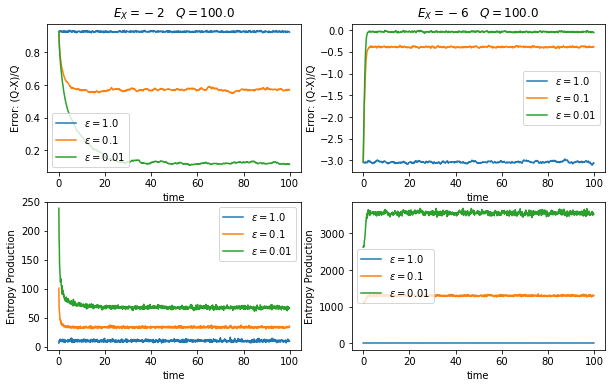

$\textrm{Entropy Production} \propto ( J_i^S(t) \log \frac{k}{\epsilon [P_i](t)} + J_i^Q(t) \log \frac{k [P_i](t)}{\epsilon})$

In [ ]:
#*********************************************************
#************* Try Changing These Variables! *************
#*********************************************************
k = 1.0 #learning rate
e_list = [k, k/10., k/100] #Epsilon Values

#Energies E_X of the untrained CRN (2 different values are compared)
E1 = -2 
E2 = -6
E_P = 0 #Energy of the potential species


#Initial Conditions
Q0 = 100 #Target Q
P0 = 0 #Initial number of potential species

Nsims = 100 #Number of simulations to average over - fewer will run faster but reduce accuracy
timepoints = np.linspace(0.0, 100.0, 1000000)
#*********************************************************
#************* Simulation and Plotting Below *************
#*********************************************************
E_list = [E1, E2] #Energies of the untrained model

Ns = len(timepoints/100) #number of timepoints to average

plt.figure(figsize = (10, 6))
for i, E_X in enumerate(E_list):
    
    ax1 = plt.subplot(100*len(E_list)+20+i+1)
    ax2 = plt.subplot(100*len(E_list)+20+3+i)
    
    for j, e in enumerate(e_list):
     
        dSdts = []
        errs = []
        for n in range(Nsims):
            E = {"X":E_X, "Q":0, "P":E_P}
            #Learning CRN
            species = ["X", "P", "Q"]
            reactions = db_rxns([], ["X", "P"], E, k = 100) #db Rection
            reactions += chemostat_reactions(["X", "P"], ["X", "P", "P"], kf = k, kr = e) #learning reaction 1
            reactions += chemostat_reactions(["Q", "P"], ["Q"], kf = k, kr = e) #learning reaction 2
            x0 = {"X":np.exp(-E_X), "Q":Q0, "P":P0}

            CRN = Model(species = species, reactions = reactions, initial_condition_dict = x0)

            results = py_simulate_model(timepoints, CRN, stochastic = True, return_dataframe = False)
            RA = results.py_get_result()
            Xi = CRN.get_species_index("X")
            Pi = CRN.get_species_index("P")
            Qi = CRN.get_species_index("Q")            
            
            dSdt = np.zeros(int(len(timepoints)/Ns))
            for i in range(len(dSdt)):
                if i < len(dSdt)-1:
                    X = np.mean(RA[Ns*i:Ns*(i+1), Xi])
                    Q = np.mean(RA[Ns*i:Ns*(i+1), Qi])
                    P = np.mean(RA[Ns*i:Ns*(i+1), Pi])
                else:
                    X = np.mean(RA[Ns*i:, Xi])
                    Q = np.mean(RA[Ns*i:, Qi])
                    P = np.mean(RA[Ns*i:, Pi])
                dSdt[i] = (k*P*X - e*P**2*X)*np.log(k/(e*P))+(k*P*Q-e*Q)*np.log(k*P/e)
            dSdts.append(dSdt)
            errs.append((RA[::Ns, Qi]-RA[::Ns, Xi])/RA[::Ns, Qi])
        
        
        plt.sca(ax1)
        plt.title(f"$E_X = {E_X} \quad Q = {Q}$")
        plt.plot(timepoints[::Ns], np.mean(np.array(errs), 0), label = f"$\epsilon = {e}$")

        plt.sca(ax2)
        plt.plot(timepoints[::Ns], np.mean(np.array(dSdts), 0), label = f"$\epsilon = {e}$")
    
    plt.sca(ax1)
    plt.xlabel("time")
    plt.ylabel("Error: (Q-X)/Q")
    plt.legend()
    
    plt.sca(ax2)
    plt.xlabel("time")
    plt.ylabel("Entropy Production")
    plt.legend()
